In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

import pandas_datareader.data as pdr

import datetime as dt
import yfinance as yf

import random
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout, Flatten, Conv2D, MaxPool2D, Input
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.wrappers.scikit_learn import KerasRegressor


import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD

from tensorflow.keras import backend as K

from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.tree import DecisionTreeRegressor

from sklearn.neighbors import KNeighborsRegressor

from sklearn.svm import SVR

# Bagging
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor

# Boosting
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import chi2, f_regression
from sklearn.feature_selection import SelectKBest

import statsmodels.tsa.arima.model as stats
import statsmodels.api as sm

from pandas.plotting import scatter_matrix
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf

In [2]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
plt.style.use('ggplot')

mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = 'grey'
mpl.rcParams['grid.alpha'] = 0.25

mpl.rcParams['legend.fontsize'] = 10

In [4]:
DATADIR = Path.cwd()

filepath = os.path.join(DATADIR, 'data_with_covid.csv')

D = pd.read_csv(filepath, index_col = [0], infer_datetime_format = True)
D.columns = (x.lower() for x in D.columns)

TRAIN_TEST_CUTOFF = int((len(D) * 0.8))

train_set = D.iloc[:TRAIN_TEST_CUTOFF, :]
test_set = D.iloc[TRAIN_TEST_CUTOFF:, :]

scaler = MinMaxScaler(feature_range = (-1, 1))
train_set_scaled = scaler.fit_transform(train_set)
test_set_scaled = scaler.transform(test_set)

Train RMSE: 0.011 RMSE
Test RMSE: 0.047 RMSE


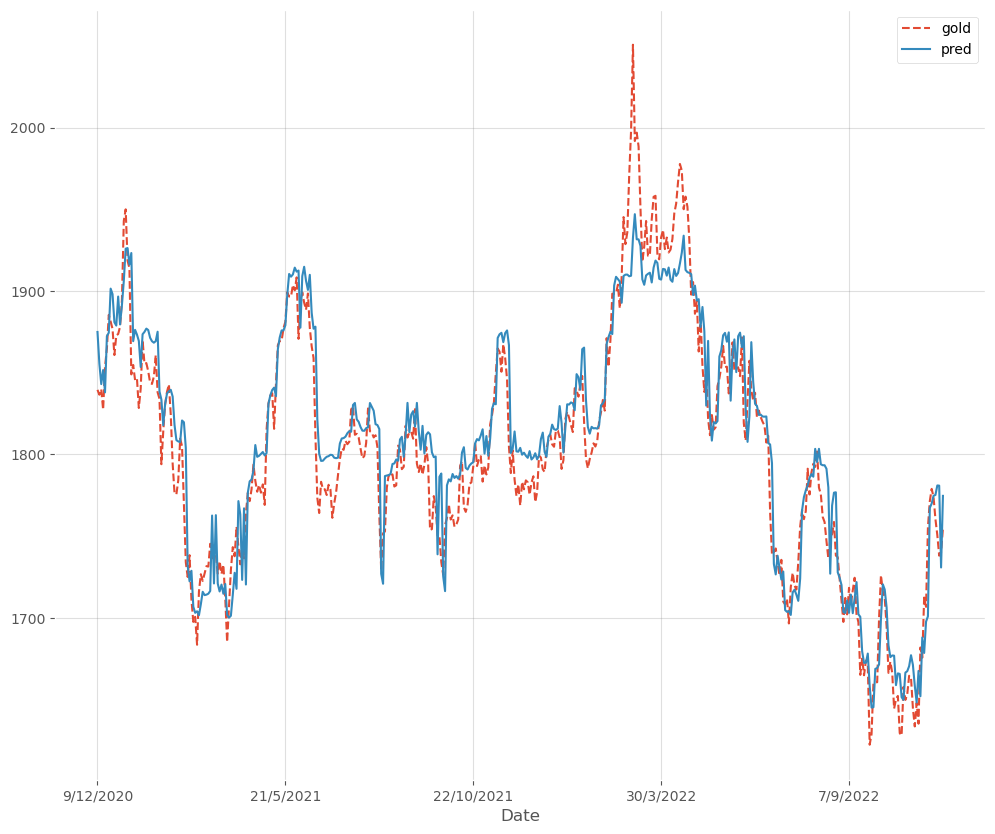

In [5]:
X_train = []
y_train = []

for i in range(len(train_set_scaled)):
    X_train.append(train_set_scaled[i, 1:])
    y_train.append(train_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

RF = RandomForestRegressor(random_state=4)

RF.fit(X_train, y_train)

X_test = []
y_test = []

for i in range(len(test_set_scaled)):
    X_test.append(test_set_scaled[i, 1:])
    y_test.append(test_set_scaled[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

predict_train = RF.predict(X_train)

predicted_stock_price = RF.predict(X_test)

predicted_stock_price = np.reshape(predicted_stock_price, (predicted_stock_price.shape[0], 1))

def print_error(trainY, testY, train_predict, test_predict):    
    ### Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    ### Print RMSE
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))

print_error(y_train, y_test, predict_train, predicted_stock_price)

pred_array = np.repeat(predicted_stock_price, len(D.columns), axis = -1)

pred = scaler.inverse_transform(pred_array)[:,0]

graph_test = pd.DataFrame(test_set.iloc[:,0])
graph_test['pred'] = pred


fig, ax = plt.subplots(figsize = (12,10))
graph_test['gold'].plot(linestyle = '--')
graph_test['pred'].plot(linestyle = '-')
ax.legend()


In [7]:
RF.feature_importances_

array([9.80440116e-01, 8.40475077e-03, 4.23279898e-04, 1.08203135e-03,
       1.81413017e-04, 1.44811815e-04, 1.43024106e-04, 1.33954152e-03,
       3.56327492e-04, 1.70231224e-04, 2.07956124e-04, 3.52197703e-04,
       9.90917104e-05, 7.69397000e-04, 1.41138033e-04, 2.05843689e-05,
       2.64759119e-04, 1.96376719e-04, 2.33849454e-04, 2.37891978e-04,
       1.85548958e-04, 1.94435636e-04, 5.09537720e-04, 5.87224164e-05,
       7.16063362e-05, 4.08545268e-05, 6.43281067e-05, 9.89418191e-05,
       4.99053786e-05, 2.07864083e-04, 4.68464398e-05, 1.35558532e-05,
       3.24908308e-03])

In [8]:
len(RF.feature_importances_)

33

In [9]:
RF.feature_importances_[-1]

0.003249083077571816

In [11]:
D.tail()

,gold,gold_lag_1,gold_lag_2,gold_lag_3,gold_lag_4,gold_lag_5,gold_lag_6,gold_lag_7,gold_lag_8,gold_lag_9,...,cpiaucsl,ppiaco,adpmnusnersa,payems,jtsjol,unrate,poilbreusdm,a191rl1q225sbea,ussthpi,sum_of_new_cases
Date,,,,,,,,,,,,,,,,,,,,,
17/11/2022,1760.44,1773.87,1778.94,1771.40,1771.24,1755.45,1706.74,1712.42,1675.63,1681.87,...,296.761,268.693,121763000,153047,10687,3.5,90.608182,-1.6,578.7,1983454
18/11/2022,1750.68,1760.44,1773.87,1778.94,1771.40,1771.24,1755.45,1706.74,1712.42,1675.63,...,296.761,268.693,121763000,153047,10687,3.5,90.608182,-1.6,578.7,2820428
21/11/2022,1738.05,1750.68,1760.44,1773.87,1778.94,1771.40,1771.24,1755.45,1706.74,1712.42,...,296.761,268.693,121763000,153047,10687,3.5,90.608182,-1.6,578.7,1539529
22/11/2022,1740.25,1738.05,1750.68,1760.44,1773.87,1778.94,1771.40,1771.24,1755.45,1706.74,...,296.761,268.693,121763000,153047,10687,3.5,90.608182,-1.6,578.7,2476923
25/11/2022,1754.93,1755.24,1749.68,1740.25,1738.05,1750.68,1760.44,1773.87,1778.94,1771.40,...,296.761,268.693,121763000,153047,10687,3.5,90.608182,-1.6,578.7,3120623
